In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=60,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


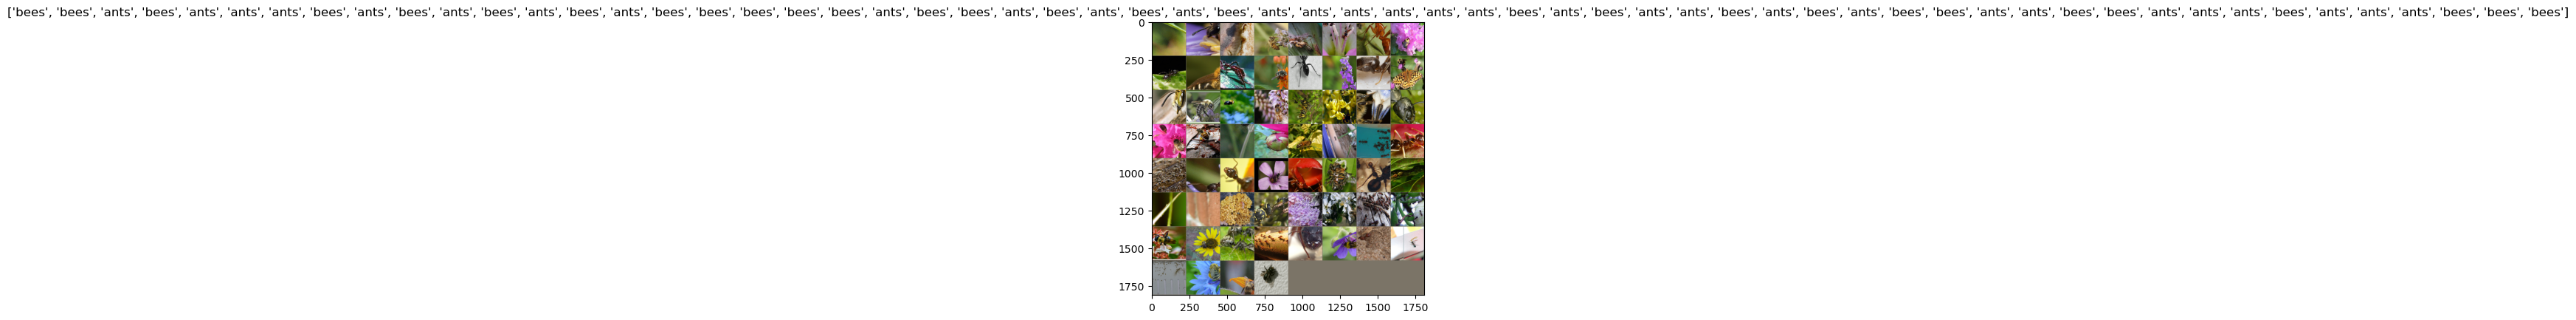

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Reference
---------------------
[Transfer Learning for Computer Vision Tutorial],
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`,
`cs231n notes <https://cs231n.github.io/transfer-learning/>`


Training
========
To load dataset with different size, change the batch_size on code block 3.

In [4]:
inputs, classes = next(iter(dataloaders['train']))
tests, test_classes = next(iter(dataloaders['val']))

print(inputs.shape)
print(tests.shape)

torch.Size([60, 3, 224, 224])
torch.Size([60, 3, 224, 224])


SVM
===

In [5]:
from sklearn import svm
clf = svm.SVC(gamma=0.001)

# Learn the digits on the train subset
clf.fit(inputs, classes)

# Predict the value of the digit on the test subset
predicted = clf.predict(tests)


ValueError: Found array with dim 4. SVC expected <= 2.

K-nn
====

In [ ]:
from sklearn import neighbors


SVM with PCA
============

K-nn with PCA
=============

Load Pre-trained CNN model
==========================

SVM and Knn with feature extractor of pre-trained CNN
================